In [ ]:
%load_ext autoreload
%autoreload 2

# Doing Data Viz in Python

Ned Letcher

[nedned.net](http://nedned.net)

### Goal of data analysis

_Derive information and insights in order to improve our understanding and inform decision making_

### Relevance of data visualisation
1. Analysise and explore
2. Communicate findings

This talk is about showing you Python tools for how to achieve these goals, and some tips for how to use them 


## Data Viz for exploratory data analysis

### Your Task

Use the Melbourne City Council [Pedestrian Counting System dataset](https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp) for answer the following question:

_How has the COVID-19 pandemic impacted foot traffic in the Melbourne CBD?_

### Data prep

In [18]:
from pathlib import Path

DATA_PATH = Path("data/Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv")

In [20]:
import pandas as pd

df = pd.read_csv(DATA_PATH)
df.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts
0,2887628,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,34,Flinders St-Spark La,300
1,2887629,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,39,Alfred Place,604
2,2887630,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,37,Lygon St (East),216
3,2887631,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627
4,2887632,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,36,Queen St (West),774


In [21]:
def load_and_clean_pedestrian_data(path):
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime(
        {
            "day": df["Mdate"],
            "year": df["Year"],
            "hour": df["Time"],
            "month": pd.to_datetime(df["Month"], format='%B').dt.month
        }
    )
    return df

df = load_and_clean_pedestrian_data(DATA_PATH)
df.head()

,ID,Date_Time,Year,Month,Mdate,Day,Time,Sensor_ID,Sensor_Name,Hourly_Counts,datetime
0,2887628,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,34,Flinders St-Spark La,300,2019-11-01 17:00:00
1,2887629,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,39,Alfred Place,604,2019-11-01 17:00:00
2,2887630,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,37,Lygon St (East),216,2019-11-01 17:00:00
3,2887631,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,40,Lonsdale St-Spring St (West),627,2019-11-01 17:00:00
4,2887632,11/01/2019 05:00:00 PM,2019,November,1,Friday,17,36,Queen St (West),774,2019-11-01 17:00:00


### Let's have a look at what's in the data

_Q: How many years does the dataset cover?_

In [31]:
YEARS = sorted(df["Year"].unique())
YEARS

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

_Q: How many sensors are in the datset?_

In [37]:
SENSORS = df["Sensor_Name"].unique()
SENSORS.shape

(69,)

_Q: How many people are recorded each year?_

In [29]:
year_counts = df.groupby("Year")["Hourly_Counts"].sum()
year_counts

Year
2009     62650110
2010     93459437
2011     90571965
2012    102215521
2013    117389820
2014    169500386
2015    209099687
2016    228757880
2017    216586414
2018    261909318
2019    266411675
2020     65584490
Name: Hourly_Counts, dtype: int64

Just eyeballing the data isn't going to cut it. Let's visualise with Pandas' plotting API.

This uses the Matplotlib library, so first set it up and configure. The first line below tells Jupyter to automatically render Matplotlib plots in the cell's output. 

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

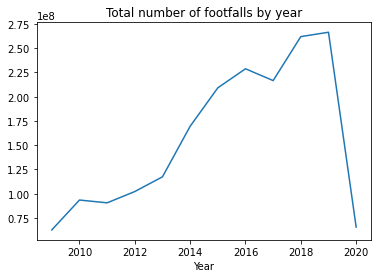

In [50]:
year_counts.plot(title="Total number of footfalls by year")

_Tip: always title your plots._

Problem is that the number of sensors increases.

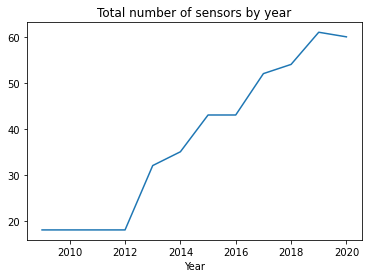

In [55]:
num_sensors = df.groupby("Year")["Sensor_Name"].nunique()
num_sensors.plot(title="Total number of sensors by year")

Let's normalise by number of sensors.

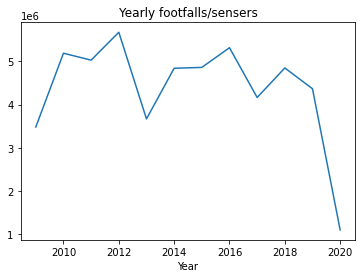

In [70]:
year_counts_df  = df.groupby("Year").agg({"Hourly_Counts":sum, "Sensor_Name": "nunique"})
year_counts_df["count_per_sensor"] = year_counts_df["Hourly_Counts"] / year_counts_df["Sensor_Name"]
year_counts_df["count_per_sensor"].plot(title="Yearly footfalls/sensers");

Not clear how helpful this is... maybe newer sensors are more likely to be in less travelled areas and our footfalls shouldn't be spread across them to the same weight as more trafficked sensors.


In [181]:
# Build up a DataFrame of sensor names with their average yearly counts and first year of existence:

# get average yearly counts
res_df = pd.DataFrame(
    df.groupby("Sensor_Name").apply(
        lambda df:df.groupby("Year")["Hourly_Counts"].sum().mean()
    ), 
    columns=["average_yearly_counts"]
)

# get first year of existence for each sensor
sorted_df = df.sort_values(by="Year")
res_df["first_year"] = [
    sorted_df[sorted_df["Sensor_Name"] == sensor].iloc[0]["Year"]
    for sensor in res_df.index
]

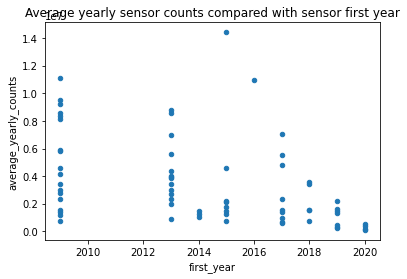

In [184]:
res_df.plot.scatter(x="first_year", y="average_yearly_counts", title="Average yearly sensor counts compared with sensor first year");

In [177]:
res_df

,average_yearly_counts,first_year
Sensor_Name,,
231 Bourke St,5.240140e+05,2020
Alfred Place,1.479692e+06,2014
Australia on Collins,4.624565e+06,2009
Birrarung Marr,2.376984e+06,2009
Bourke St - Spencer St (North),3.449340e+06,2018
...,...,...
Tin Alley-Swanston St (West),7.214050e+05,2015
Town Hall (West),1.113845e+07,2009
Victoria Point,1.407888e+06,2009


### Pandas' plotting API
* Built on Matplotlib (has its own API, which Pandas hides)
* Really useful for quick exploratory visualisation of data in `DataFrame`s and `series`

### Limitations
* Pandas plotting API is limited
** Can break out into full Matplotlib's API
** Matplotlib is very powerful, but can slow/hard to learn
* static image: can’t zoom or toggle visibility of data
* 

### Using Matplotlib's API with Pandas

TODO: plot that returns a an ax and then does stuff with it

### Matplotlib Themes
TODO

### Use Seaborn

Seaborn is a library built on top of Matplotlib. Provides:

* API designed for statistical graphing
* Recipes for producing specialised plots
* Imporved visual appearance

**Links**
* [Seaborn Overview](https://seaborn.pydata.org/introduction.html)
* [Seaborn Gallery](https://seaborn.pydata.org/examples/index.html)

Can just use to get improved visuals: TODO one liner import and then re-run plots 

## Other Python Libraries

TODO: add python data viz landscape